This jupyter notebook will attempt to find clusters / communities in the network with Association, Laplacian, Modularity, Topographic Modularity using spectral methods.  I will compute eigenvectors on undirected global trade network (symmetrizing Adjacency Matrix). I will also (first actually) compute SVD on the directed network (unsymmetrized). I have two directed network options - (1). with total import on diagonal & (2). with total export on diagonal.

Data about world trade statistics from https://atlas.media.mit.edu/de/resources/data/

In [1]:
import numpy as np              #
import pandas as pd             #
import matplotlib.pyplot as plt #
import matplotlib.cm as cm      #
import time                     # 
import os                       #
import csv                      #
import networkx as nx           # construct, manipulate and plot graph objects
#import community                # community detection in graphs (partition, modularity, etc.)
import sys                      # to check which computer you are on (mine, or cluster, or other?)
import scipy.sparse as sp       # library to deal with sparse graphs for Cuthill-Mckee and Laplacian
from mpl_toolkits.mplot3d import Axes3D # for 3D plotting of SVD's   

In [2]:
# (0b). Check what Operating System you are on (either my machine or Cortex cluster) and adjust directory structure accordingly.
if sys.platform == 'darwin':
	print('on Mac OS - assuming Chris laptop')
	dirPre = '../../'
elif sys.platform == 'linux' or sys.platform == 'linux2':
	print('on Linux - assuming Cortex Cluster')
	dirPre = '../../'

on Mac OS - assuming Chris laptop


In [3]:
# (1). Load country names that align with 3 letter acronyms used in origin destination file
if True:
	fcountries = str(dirPre + 'MIT_WT_datafiles/country_names.tsv')
	countriesInfo = os.stat(fcountries)
	#print('Size of ' + fcountries + ' is ' + str(countriesInfo.st_size/10**(6)) + 'MB')

	t = time.time()
	countries = pd.read_table(fcountries, sep='\t')
	num_countries = np.size(countries,0)    
 
	# Get array indicating continents for each country to colorcode nodes in graph.
	continent=[]
	for o in range(0,num_countries):
		reg = countries.id[o]
		continent = np.append(continent,reg[0:2])       
	conts = set(continent) # this is a 'set object' (all the different countries)
	conts = list(conts) # convert 'set object' to a list that I can iterate over.
	conts = np.sort(conts)
	node_colors_by_continent = np.zeros(len(continent))
	for i in range(0,len(conts)):
		node_colors_by_continent[ np.array(continent == conts[i]) ] = i
    
	elapsed = time.time() - t
	#print( str(elapsed) + " seconds to load")

	countries.head(5) # NOTE: in id column, 1st 2 letters indicate world region.

In [4]:
# (2). Load a previously saved adjacency matrix files:
if True:
	years = [1985] #range(1962,2014)
	y=0
	a=263
	loaded = np.load(str(dirPre + "adjacency_ntwrk_npz_files/adjacency_ntwrk_" + str(years[y]) + "_" + str(a) + "countries.npz"))
	trade_ntwrkA = loaded['netwrk']
	tradeCountry_import = loaded['imprt']
	tradeCountry_export = loaded['exprt']
	loaded.close()
    
	b=2 # get rid of 'world' and 'areas' from trade network
	a=a-b
	trade_ntwrkA = trade_ntwrkA[range(0,a),:][:,range(0,a)]
	tradeCountry_import = tradeCountry_import[range(0,a)]
	tradeCountry_export = tradeCountry_export[range(0,a)]

In [5]:
print(trade_ntwrkA.shape)
print(tradeCountry_import.shape)
print(tradeCountry_export.shape)


(261, 261)
(261,)
(261,)


In [8]:
method="Laplacian"

In [6]:
# (3). Plot adjacency matrix and total imports / exports from each country.
if False:
    
	%matplotlib inline
	plt.figure(figsize=(15,15))

	plt.subplot(2,1,1)
	plt.imshow( np.log(trade_ntwrkA), interpolation='none' )
	plt.title("Global Trade Network in " + str(years[y]))
	plt.colorbar(fraction=0.046, pad=0.04)
	plt.xticks( range(0,a), countries.id_3char[0:a] )
	plt.yticks( range(0,a), countries.id_3char[0:a] )
    
	plt.subplot(2,2,3)
	imprt = plt.plot( np.log(tradeCountry_import))#, label="import" )
	exprt = plt.plot( np.log(tradeCountry_export))#, label="export" )
	meanIE = plt.plot( np.log( np.mean([tradeCountry_import,tradeCountry_export],axis=0) ))
	plt.title("Import & Export for Individual Countries")
	plt.ylabel("Log of Trade Value")
	plt.xlabel("Country")
	plt.xticks( range(0,a), countries.id_3char[0:a] )
	plt.legend(["Imports","Exports","Avg of I&E"])
    
	plt.subplot(2,2,4)
	imprt = plt.plot( np.log( tradeCountry_import - tradeCountry_export) )
	plt.title("Difference between Import & Export")
	plt.ylabel("Log Diff Trade Value")
	plt.xlabel("Country")
	plt.xticks( range(0,a), countries.id_3char[0:a] )

In [7]:
# (4). Check that Imports are just the column sums and Exports are row sums

#print('Imports')
#print( np.sum(trade_ntwrkA,axis=0) )
#print( tradeCountry_import )
assert np.any( np.sum(trade_ntwrkA,axis=0) == tradeCountry_import) , 'Imports are Weird'

#print('Exports')
#print( np.sum(trade_ntwrkA,axis=1) )
#print( tradeCountry_export )
assert np.any( np.sum(trade_ntwrkA,axis=1) == tradeCountry_export) , 'Exports are Weird'

print('Everything checks out with sums, imports and exports.')

Everything checks out with sums, imports and exports.


In [8]:
# (5a). Construct two weighted, directed networks with either total imports or exports on diagonal.
trade_ntwrkA_Imports = trade_ntwrkA + np.diag(tradeCountry_import)
trade_ntwrkA_Exports = trade_ntwrkA + np.diag(tradeCountry_export)


In [9]:
# (5b). Find Cuthill-McKee reordering of Adjacency Matrix and Compute Normalized Laplacian
#       NOTE: CM requires sparse matrices and scipy's sparse library.
if True:
	trade_ntwrkA_sp = sp.csc_matrix(trade_ntwrkA) # sparse version of Adjacency for CM
	perm = sp.csgraph.reverse_cuthill_mckee(trade_ntwrkA_sp,symmetric_mode=False)
	trade_ntwrkLn = sp.csgraph.laplacian(trade_ntwrkA,normed=True)

In [10]:
'''
# (5c). Compute Modularity of Global Trade Network 
#


G = nx.Graph()

G = nx.read_weighted_edgelist('graphs/fashionGraph_1.edgelist')
nx.transitivity(G)

# Find modularity
part = community.best_partition(G)
mod = community.modularity(part,G)

# Plot, color nodes using community structure
values = [part.get(node) for node in G.nodes()]
nx.draw_spring(G, cmap=plt.get_cmap('jet'), node_color = values, node_size=30, with_labels=False)
plt.show()
'''

"\n# (5c). Compute Modularity of Global Trade Network \n#\n\n\nG = nx.Graph()\n\nG = nx.read_weighted_edgelist('graphs/fashionGraph_1.edgelist')\nnx.transitivity(G)\n\n# Find modularity\npart = community.best_partition(G)\nmod = community.modularity(part,G)\n\n# Plot, color nodes using community structure\nvalues = [part.get(node) for node in G.nodes()]\nnx.draw_spring(G, cmap=plt.get_cmap('jet'), node_color = values, node_size=30, with_labels=False)\nplt.show()\n"

Reordered Countries
241                      Tokelau
47         Sao Tome and Principe
112                  Timor-Leste
43                  Saint Helena
70                        Bhutan
253             Falkland Islands
23             Equatorial Guinea
219       British Virgin Islands
214     Turks and Caicos Islands
178                     Anguilla
121                      Andorra
213    Saint Pierre and Miquelon
192                     Dominica
84                         Japan
141               United Kingdom
149                        Italy
139                       France
133                      Germany
160                  Netherlands
134                      Denmark
135                        Spain
123                      Belgium
173                       Sweden
122                      Austria
147                      Ireland
128                  Switzerland
163                     Portugal
217                United States
138                      Finland
76                     

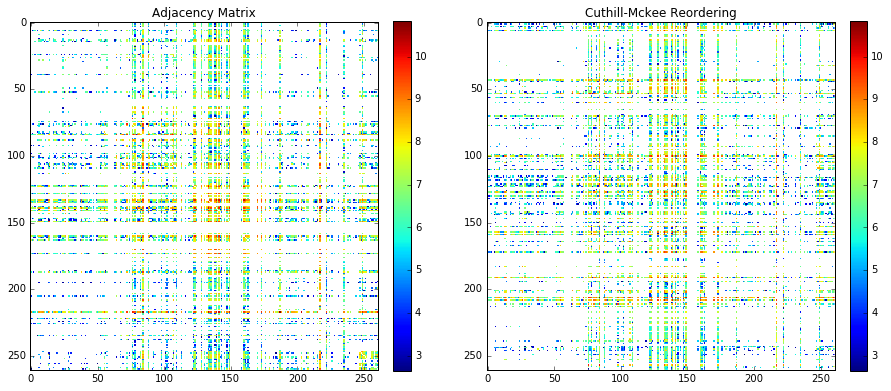

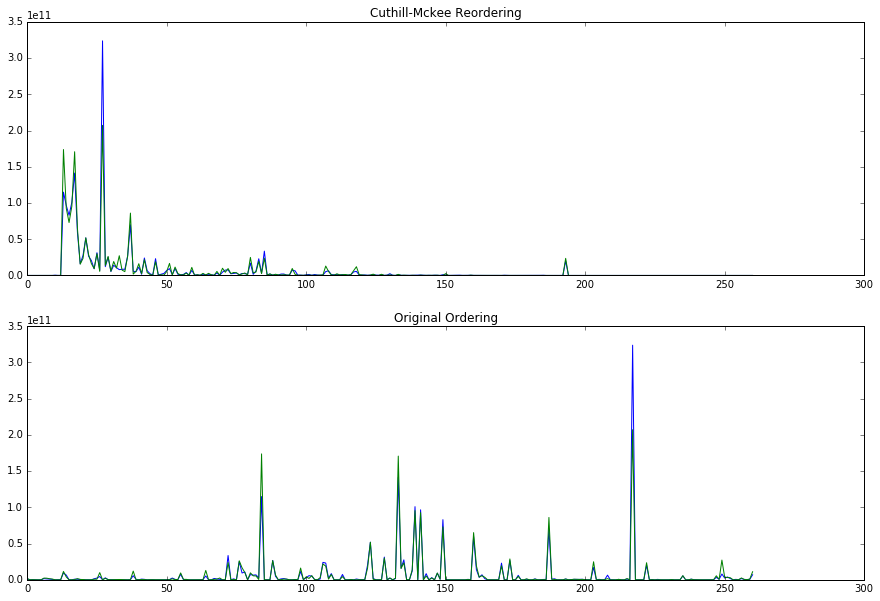

In [11]:
# (5c). Plot Cuthill-Mckee reordering of Adjacency Matrix. 
if True:
	%matplotlib inline
	plt.figure(figsize=(15,15))
    
    # Plot Adjacency
	plt.subplot(1,2,1)
	plt.imshow( np.log10(trade_ntwrkA), interpolation='none' )
	plt.title("Adjacency Matrix")
	plt.colorbar(fraction=0.046, pad=0.04)
    
    # Plot reordered Adjacency
	plt.subplot(1,2,2)
	plt.imshow( np.log10(trade_ntwrkA[perm][perm]), interpolation='none' )
	plt.title("Cuthill-Mckee Reordering")
	plt.colorbar(fraction=0.046, pad=0.04)
    
	print("Reordered Countries")    
	print(countries.name[perm[0:40]])
    
    # Plot Imports and Exports reordered by Cuthill-Mckee algorithm
	plt.figure(figsize=(15,10))
	plt.subplot(2,1,1)
	plt.plot(tradeCountry_import[perm])
	plt.plot(tradeCountry_export[perm])
	plt.title("Cuthill-Mckee Reordering")
    #
	plt.subplot(2,1,2)
	plt.plot(tradeCountry_import)
	plt.plot(tradeCountry_export)
	plt.title("Original Ordering")

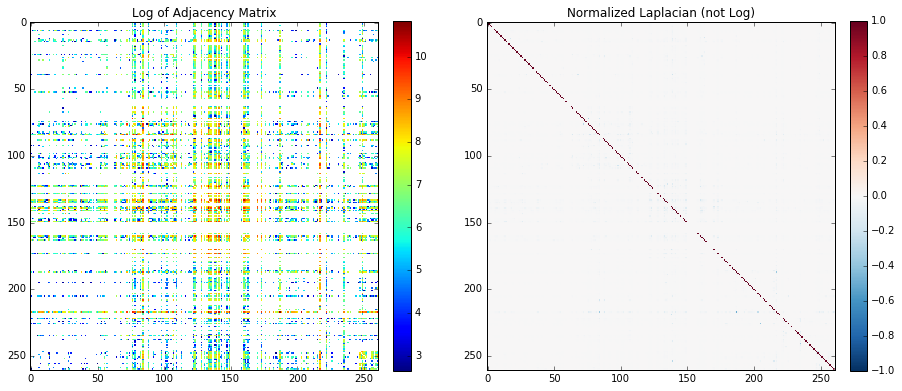

In [13]:
# (5d). Plot Laplacian, Adjacency and Normalized Laplacian    
if True:
	%matplotlib inline
	plt.figure(figsize=(15,15))
    
    # Plot Adjacency
	plt.subplot(1,2,1)
	plt.imshow( np.log10(trade_ntwrkA), interpolation='none' )
	plt.title("Log of Adjacency Matrix")
	plt.colorbar(fraction=0.046, pad=0.04)
    
    # Plot Laplacian (normalized)
	plt.subplot(1,2,2)
	plt.imshow( (trade_ntwrkLn), interpolation='none', cmap='RdBu_r', 
               vmin=-np.max( np.abs( trade_ntwrkLn ) ) , vmax=np.max( np.abs( trade_ntwrkLn ) ) )
	plt.title("Normalized Laplacian (not Log)")
	plt.colorbar(fraction=0.046, pad=0.04)    

In [14]:
# (6). Compute Singular Value Decomposition on Adjacency, Normalized Laplacian
UiA, SiA, ViA = np.linalg.svd( trade_ntwrkA, full_matrices=True, compute_uv=True ) # Adjacency

UiL, SiL, ViL = np.linalg.svd( trade_ntwrkLn, full_matrices=True, compute_uv=True ) # Laplacian

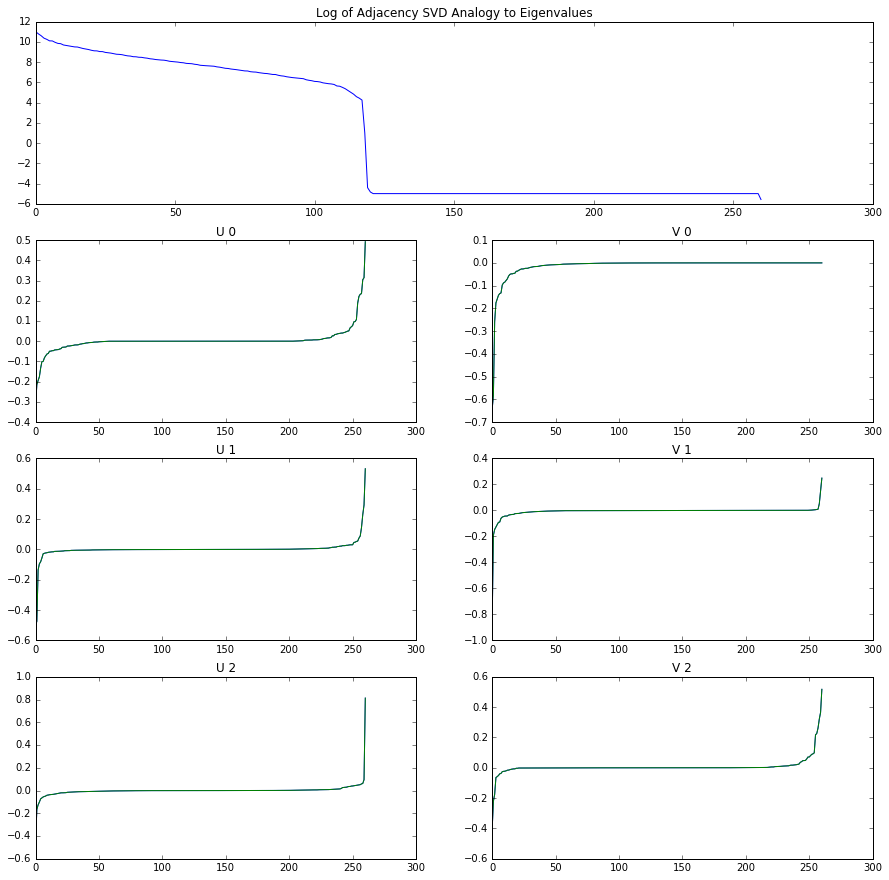

In [15]:
# (7a). Plot first couple singular values for Adjacency (Ui = left side one, Vi = right side one)
if True:

	%matplotlib inline
	plt.figure(figsize=(15,15))

	plt.subplot(4,1,1)
	plt.plot( np.log10(SiA) )
	plt.title("Log of Adjacency SVD Analogy to Eigenvalues")

	numSVDs = 3 # number of SVDs
	for p in range(0,numSVDs):
    
		plt.subplot(4,2,(3+p*2) )
		plt.plot( np.sort(UiA[p][:]) )
		plt.plot( np.sort(UiA[:][p]) )
		plt.title(str("U "+ str(p)) )  
                  
		plt.subplot(4,2,(4+p*2) )
		plt.plot( np.sort(ViA[p][:]) )
		plt.plot( np.sort(ViA[:][p]) )
		plt.title(str("V "+ str(p)) )

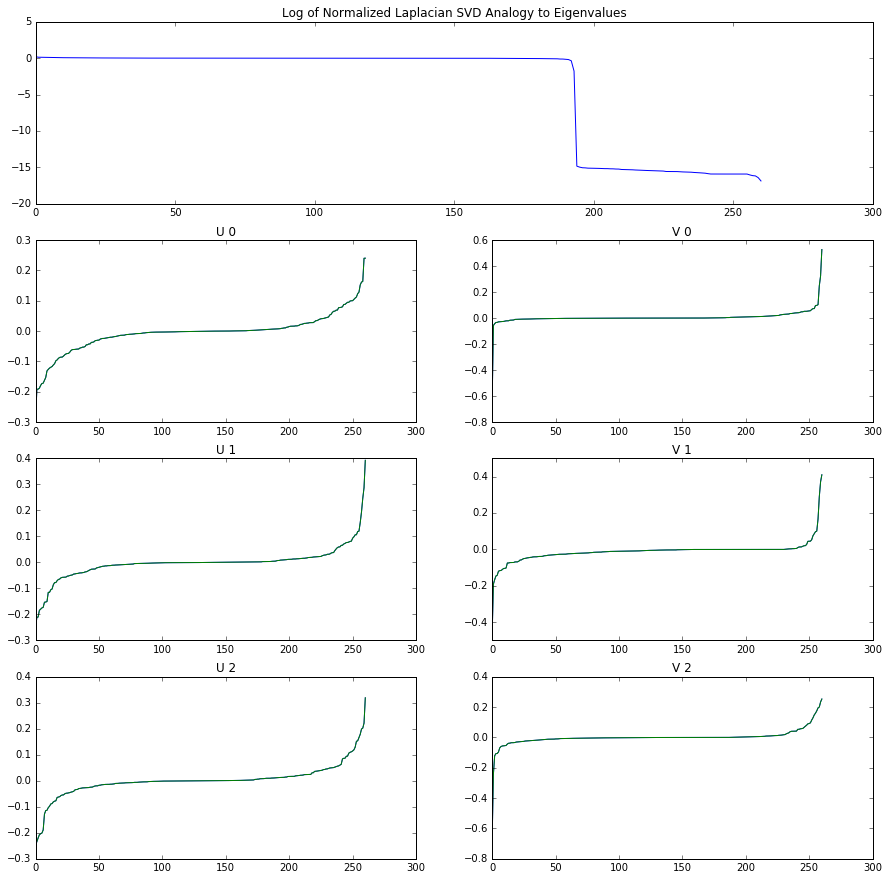

In [16]:
# (7b). Plot first couple singular values for Laplacian (Ui = left side one, Vi = right side one)
if True:

	%matplotlib inline
	plt.figure(figsize=(15,15))

	plt.subplot(4,1,1)
	plt.plot( np.log10(SiL) )
	plt.title("Log of Normalized Laplacian SVD Analogy to Eigenvalues")

	numSVDs = 3 # number of SVDs
	for p in range(0,numSVDs):
    
		plt.subplot(4,2,(3+p*2) )
		plt.plot( np.sort(UiL[p][:]) )
		plt.plot( np.sort(UiL[:][p]) )
		plt.title(str("U "+ str(p)) )  
                  
		plt.subplot(4,2,(4+p*2) )
		plt.plot( np.sort(ViL[p][:]) )
		plt.plot( np.sort(ViL[:][p]) )
		plt.title(str("V "+ str(p)) )

In [17]:
# (8). Plot whole U and V matrices. It looks like Ui = Vi' for all.
#      NOTE: Don't need plot because we check this in assertion statements below.
if False:   
	%matplotlib inline
	plt.figure(figsize=(15,15))
	plt.set_cmap('bwr')
    
	plt.subplot(2,2,1)
	plt.imshow( UiA, interpolation='none' )
	plt.title("SVD's U in trade network in " + str(years[y]))
	plt.colorbar(fraction=0.046, pad=0.04)
	plt.xticks( range(0,a), countries.id_3char[0:a] )
	plt.yticks( range(0,a), countries.id_3char[0:a] )

	plt.subplot(2,2,2)
	plt.imshow( ViA.transpose(), interpolation='none' )
	plt.title("SVD's V' in trade network in " + str(years[y]))
	plt.colorbar(fraction=0.046, pad=0.04)
	plt.xticks( range(0,a), countries.id_3char[0:a] )
	plt.yticks( range(0,a), countries.id_3char[0:a] )    
    
	plt.subplot(2,2,3)
	plt.imshow( UiA.transpose(), interpolation='none' )
	plt.title("SVD's U' in trade network in " + str(years[y]))
	plt.colorbar(fraction=0.046, pad=0.04)
	plt.xticks( range(0,a), countries.id_3char[0:a] )
	plt.yticks( range(0,a), countries.id_3char[0:a] )
    
	plt.subplot(2,2,4)
	plt.imshow( ViA, interpolation='none' )
	plt.title("SVD's V in trade network in " + str(years[y]))
	plt.colorbar(fraction=0.046, pad=0.04)
	plt.xticks( range(0,a), countries.id_3char[0:a] )
	plt.yticks( range(0,a), countries.id_3char[0:a] )    

In [18]:
# (9). Check that Ui and Vi' the same thing? They should be

assert np.any( UiA.transpose() == ViA) , 'uh oh, for Adjacency, they arent'
print('For Adjacency, Ui is transpose of Vi')

assert np.any( UiL.transpose() == ViL) , 'uh oh, for Laplacian, they arent'
print('For Normalized Laplacian, Ui is transpose of Vi')

For Adjacency, Ui is transpose of Vi
For Normalized Laplacian, Ui is transpose of Vi


In [19]:
# (10a). Look at clusters found with first couple individual Adjacency SVDs.

if True:
    
	c=5         # number of countries to show for each Singular Value.
	numSVDs = 2 # number of SVDs
    
	print("For Adjacency")
    
	for e in range(0,numSVDs):
    
		print(str('SVD Vec #' + str(e)))
		Y = ViA[e][:]      # array to be sorted
		x = np.sort(Y)    # array sorted from smallest to largest
		z = np.argsort(Y) # returns indexes of sorted array

		#print(y)
		#print(x)
		#print(z)
		#print( y[z] )

		print('Largest Positive')
		print( countries.name[z[0:c]] )
		print( continent[z[0:c]] )

		print('Largest negative')
		print( countries.name[z[-1-c:-1]] )
		print( continent[z[-1-c:-1]] )


For Adjacency
SVD Vec #0
Largest Positive
84              Japan
187            Canada
133           Germany
141    United Kingdom
203            Mexico
Name: name, dtype: object
['as' 'na' 'eu' 'eu' 'na']
Largest negative
151    Liechtenstein
150           Kosovo
146      Isle of Man
144          Croatia
165           Russia
Name: name, dtype: object
['eu' 'eu' 'eu' 'eu' 'eu']
SVD Vec #1
Largest Positive
217    United States
133          Germany
160      Netherlands
139           France
123          Belgium
Name: name, dtype: object
['na' 'eu' 'eu' 'eu' 'eu']
Largest negative
252      Ecuador
76     Hong Kong
260    Venezuela
203       Mexico
84         Japan
Name: name, dtype: object
['sa' 'as' 'sa' 'na' 'as']


In [20]:
# (10b). Look at clusters found with first couple individual Laplacian SVDs.

if True:
    
	c=5         # number of countries to show for each Singular Value.
	numSVDs = 2 # number of SVDs
    
	print("For Laplacian")
    
	for e in range(0,numSVDs):
    
		print(str('SVD Vec #' + str(e)))
		Y = ViL[e][:]      # array to be sorted
		x = np.sort(Y)    # array sorted from smallest to largest
		z = np.argsort(Y) # returns indexes of sorted array

		#print(y)
		#print(x)
		#print(z)
		#print( y[z] )

		print('Largest Positive')
		print( countries.name[z[0:c]] )
		print( continent[z[0:c]] )

		print('Largest negative')
		print( countries.name[z[-1-c:-1]] )
		print( continent[z[-1-c:-1]] )



For Laplacian
SVD Vec #0
Largest Positive
217           United States
72                    China
64     United Arab Emirates
100                    Oman
208                  Panama
Name: name, dtype: object
['na' 'as' 'as' 'as' 'na']
Largest negative
88     South Korea
76       Hong Kong
260      Venezuela
203         Mexico
84           Japan
Name: name, dtype: object
['as' 'as' 'sa' 'na' 'as']
SVD Vec #1
Largest Positive
72                    China
106            Saudi Arabia
187                  Canada
64     United Arab Emirates
77                Indonesia
Name: name, dtype: object
['as' 'as' 'na' 'as' 'as']
Largest negative
135            Spain
107        Singapore
217    United States
139           France
76         Hong Kong
Name: name, dtype: object
['eu' 'as' 'na' 'eu' 'as']


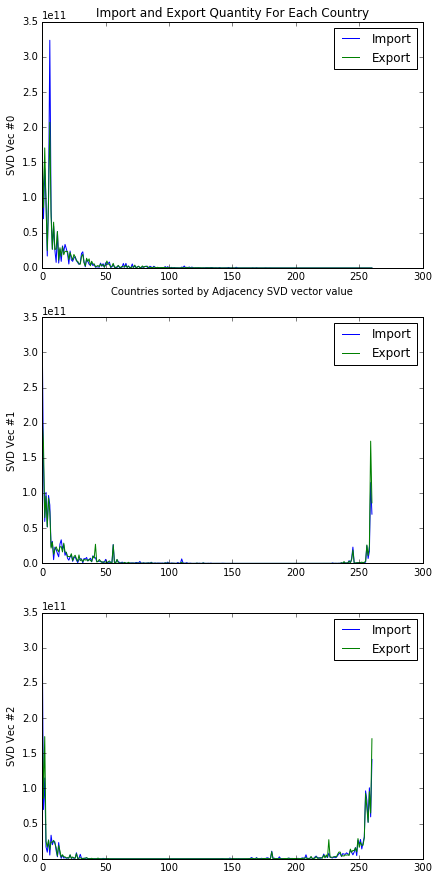

In [21]:
# (11a). Plot the total Import and Export of countries against their order in the Adjacency SVD found above.
if True:
    
	%matplotlib inline
	plt.figure(figsize=(15,15))
	numSVDs = 3
    
	for e in range(0,numSVDs):
        
		Y = ViA[e][:]      # array to be sorted
		x = np.sort(Y)    # array sorted from smallest to largest
		z = np.argsort(Y) # returns indexes of sorted array

		plt.subplot(numSVDs, 2, 2*e+1)    
		plt.plot( ( tradeCountry_import[z]) )
		plt.plot( ( tradeCountry_export[z]) )
		plt.legend(['Import','Export'])
		plt.ylabel( str('SVD Vec #' + str(e)) )

		if e==0:
			plt.title("Import and Export Quantity For Each Country")
			plt.xlabel( "Countries sorted by Adjacency SVD vector value" )

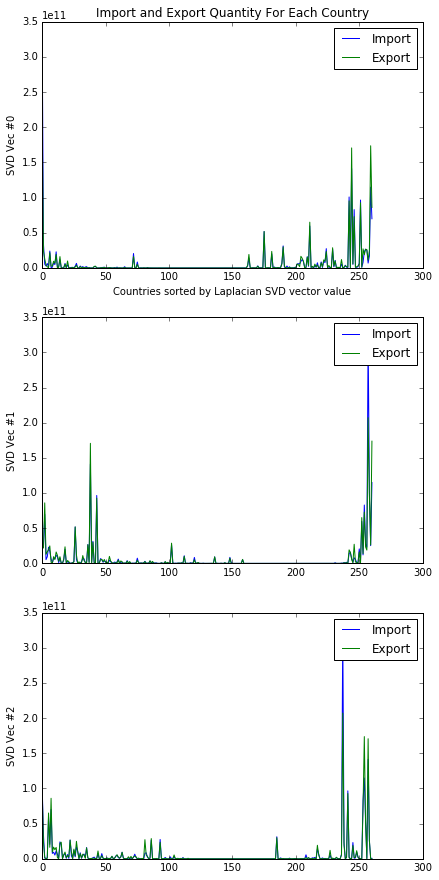

In [22]:
# (11b). Plot the total Import and Export of countries against their order in the Laplacian SVD found above.
if True:
    
	%matplotlib inline
	plt.figure(figsize=(15,15))
	numSVDs = 3
    
	for e in range(0,numSVDs):
        
		Y = ViL[e][:]      # array to be sorted
		x = np.sort(Y)    # array sorted from smallest to largest
		z = np.argsort(Y) # returns indexes of sorted array

		plt.subplot(numSVDs, 2, 2*e+1)    
		plt.plot( ( tradeCountry_import[z]) )
		plt.plot( ( tradeCountry_export[z]) )
		plt.legend(['Import','Export'])
		plt.ylabel( str('SVD Vec #' + str(e)) )

		if e==0:
			plt.title("Import and Export Quantity For Each Country")
			plt.xlabel( "Countries sorted by Laplacian SVD vector value" )

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 261 but corresponding boolean dimension is 263


Japan -0.645360104531 0.155027729555 -0.175297649107
Belgium -0.0701949051964 -0.108642377938 0.263013944603
Germany -0.258877956087 -0.191124743918 0.517680048729
France -0.14245815874 -0.127146479414 0.32162986158
United Kingdom -0.17604859736 -0.0913099822567 0.217503393693
Italy -0.132295126214 -0.0888585612695 0.226488086904
Netherlands -0.0880287576982 -0.146070228411 0.365518416288
Canada -0.584217328335 0.248985699975 -0.220665520081
Mexico -0.158516737003 0.0522116586125 -0.0640043908671
United States -0.134876897458 -0.885740279181 -0.413783923715


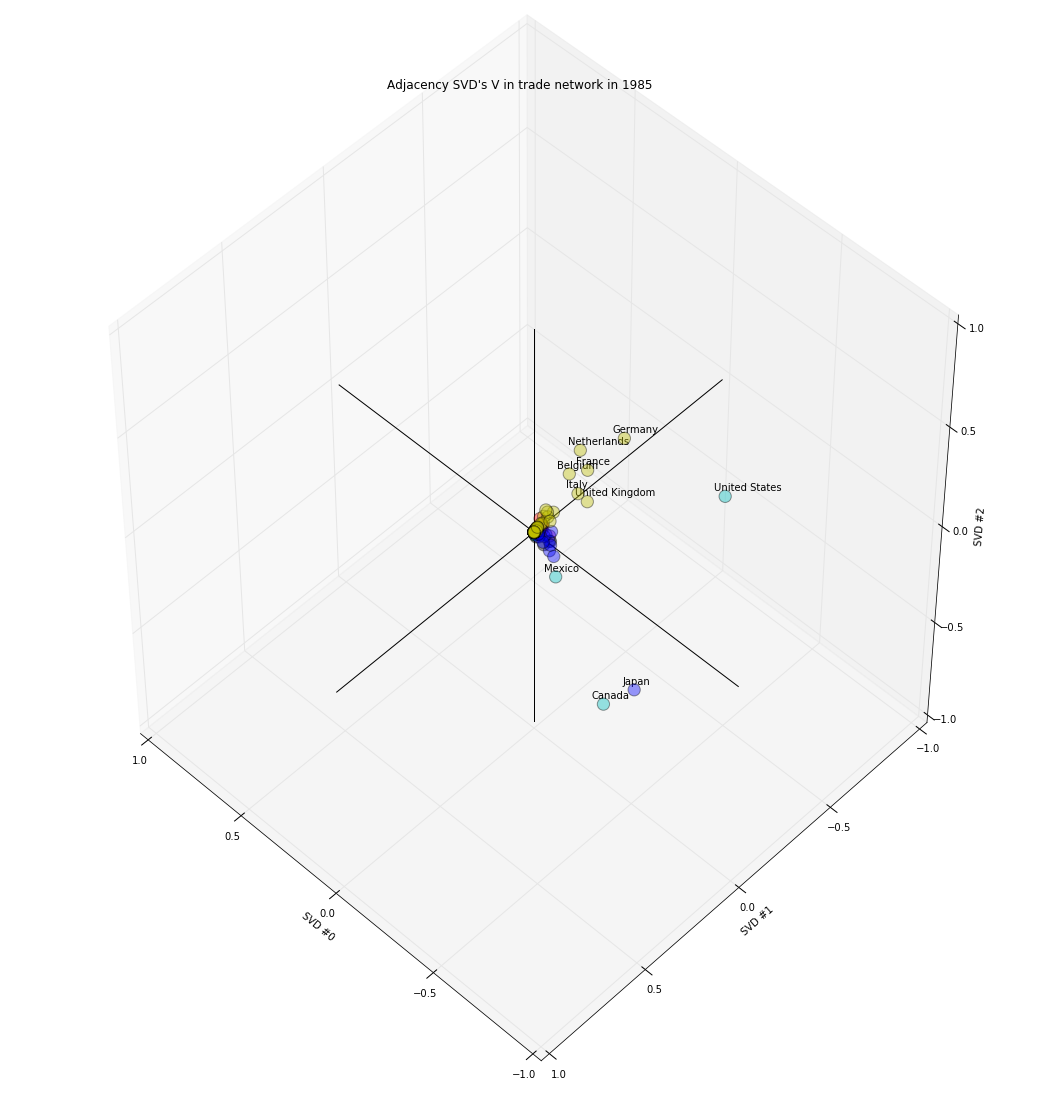

In [23]:
# (12a). Plot countries in 3D space where locations are values in 1st 3 Adjacency SVD vector.
if True:
    
	%matplotlib inline
	fig=plt.figure(figsize=(15,15))
    
	colors = ['r', 'g', 'b', 'y', 'c', 'm', 'k']

    
# Plot first couple SVD.    
	ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
    
	for i in range(0,7):
		indx = node_colors_by_continent==i
		ax.scatter(ViA[0][indx], ViA[1][indx], ViA[2][indx], s=150, edgecolor='k', c=colors[i], alpha=0.4)
    
    
	lims=1    
	ax.set_xlim(-lims,lims)
	ax.set_ylim(-lims,lims)
	ax.set_zlim(-lims,lims)    

	gt=0.1
	for i,cname in countries.name.iteritems():       
		if i<a:
			if np.any([np.abs(ViA[0][i])>gt, np.abs(ViA[1][i])>gt, np.abs(ViA[2][i])>gt]):   
				print( str( cname + " " + str(ViA[0][i])  + " " +  str(ViA[1][i]) ) + " " +  str(ViA[2][i]) )
				ax.text( ViA[0][i]+0.03, ViA[1][i]+0.03, ViA[2][i]+0.03, cname ) 
            
	ax.set_xlabel( 'SVD #0' )
	ax.set_ylabel( 'SVD #1' )
	ax.set_zlabel( 'SVD #2' )
    
	x = np.linspace(-lims,lims,2)
    
	ax.plot(x, 0*x, 0*x, color='k' ) 
	ax.plot(0*x, x, 0*x, color='k' ) 
	ax.plot(0*x, 0*x, x, color='k' ) 

	plt.title("Adjacency SVD's V in trade network in " + str(years[y]))   

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 261 but corresponding boolean dimension is 263


Reunion -0.00778663638996 -0.0717910581743 0.234264555109
United Arab Emirates -0.0425098342698 -0.145887627788 -0.0539651079391
Bahrain -0.00312156498791 0.0045482776386 -0.105689267018
China -0.0569659623011 -0.476303835228 -0.243224084143
Hong Kong 0.097928367733 0.371911695007 0.201130356811
Indonesia 0.0105095189343 -0.142045986814 -0.0550973386217
Iran -0.0253443606934 -0.104480180891 -0.0329766096765
Iraq -0.00984047771916 -0.103840450169 0.0408919904687
Japan 0.325025512545 0.410442668544 0.148690540357
Malaysia -0.0161882397567 -0.101973868851 -0.0525417597409
Saudi Arabia -0.0277921614674 -0.190760075194 -0.0372590376841
Singapore 0.0732657540817 0.1008771654 0.0598663771771
Andorra -0.00841687794963 -0.0717745572624 0.114910553138
Belgium 0.00185111531068 -0.0490552614535 0.160534125053
Germany 0.0486954286026 -0.0384196446519 0.195109582873
France 0.0419263776414 0.290416144425 -0.686052323948
Italy 0.0523116261038 0.0866124987828 0.129677164489
USSR -0.0210941618978 -0.119

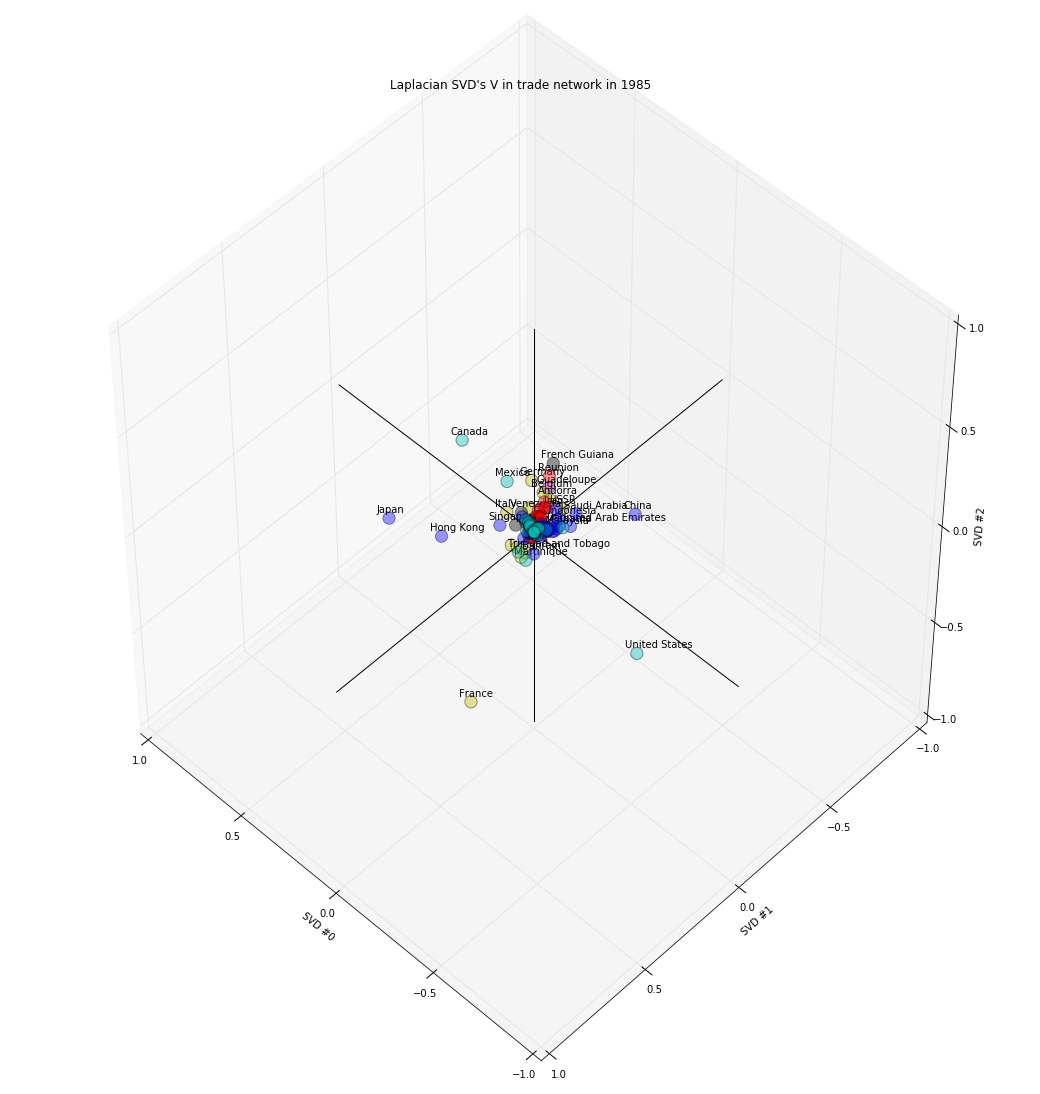

In [24]:
# (12b). Plot countries in 3D space where locations are values in 1st 3 Laplacian SVD vector.
if True:
    
	%matplotlib inline
	fig=plt.figure(figsize=(15,15))
    
	colors = ['r', 'g', 'b', 'y', 'c', 'm', 'k']

    
# Plot first couple SVD.    
	ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
    
	for i in range(0,7):
		indx = node_colors_by_continent==i
		ax.scatter(ViL[0][indx], ViL[1][indx], ViL[2][indx], s=150, edgecolor='k', c=colors[i], alpha=0.4)
    
	lims=1    
	ax.set_xlim(-lims,lims)
	ax.set_ylim(-lims,lims)
	ax.set_zlim(-lims,lims)    

	gt=0.1
	for i,cname in countries.name.iteritems():       
		if i<a:
			if np.any([np.abs(ViL[0][i])>gt, np.abs(ViL[1][i])>gt, np.abs(ViL[2][i])>gt]):   
				print( str( cname + " " + str(ViL[0][i])  + " " +  str(ViL[1][i]) ) + " " +  str(ViL[2][i]) )
				ax.text( ViL[0][i]+0.03, ViL[1][i]+0.03, ViL[2][i]+0.03, cname ) 
            
	ax.set_xlabel( 'SVD #0' )
	ax.set_ylabel( 'SVD #1' )
	ax.set_zlabel( 'SVD #2' )
    
	x = np.linspace(-lims,lims,2)
    
	ax.plot(x, 0*x, 0*x, color='k' ) 
	ax.plot(0*x, x, 0*x, color='k' ) 
	ax.plot(0*x, 0*x, x, color='k' ) 

	plt.title("Laplacian SVD's V in trade network in " + str(years[y]))   

In [25]:
# (13). Check how many values in each individual SVD vector are larger than some value (gt)
if True:
	print("Adjacency")    
	print(np.where(np.abs(ViA[0][:])>gt))
	print(np.where(np.abs(ViA[1][:])>gt))
	print(np.where(np.abs(ViA[2][:])>gt))
    
	print("Laplacian")
	print(np.where(np.abs(ViL[0][:])>gt))
	print(np.where(np.abs(ViL[1][:])>gt))
	print(np.where(np.abs(ViL[2][:])>gt))

Adjacency
(array([ 84, 133, 139, 141, 149, 187, 203, 217]),)
(array([ 84, 123, 133, 139, 160, 187, 217]),)
(array([ 84, 123, 133, 139, 141, 149, 160, 187, 217]),)
Laplacian
(array([ 84, 187, 203, 217, 260]),)
(array([ 64,  72,  76,  77,  80,  81,  84,  98, 106, 107, 139, 170, 187,
       203, 208, 217, 254]),)
(array([ 39,  68,  72,  76,  84, 121, 123, 133, 139, 149, 205, 215, 226, 254]),)


In [26]:
# (14). Do K-means clustering
if True:

	from sklearn.cluster import KMeans
	X = np.vstack( ( Vi[0][:], Vi[1][:], Vi[2][:], Vi[3][:] ) )
	print(X.shape)
	kmeans = KMeans(n_clusters=4).fit(X)
	print(kmeans.labels_)

#kmeans.cluster_centers_


NameError: name 'Vi' is not defined

In [ ]:
# (15). Some Cluster Quality Metrics - based on network structure
#
# like Conductance, Density, Modularity, etc...

In [ ]:
# (16). Connect Discrete changes in clustering / network structure to historic events.
#
# look in SpecNet ClusterQuality.py function